In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Upload train_subtask1.csv")
uploaded1 = files.upload()

df1 = pd.read_csv("train_subtask1.csv")

# Ensure timestamp is datetime
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1['is_words'] = df1['is_words'].astype(bool)

# Add text length features
df1['text_length'] = df1['text'].str.len()
df1['word_count'] = df1['text'].str.split().str.len()

Upload train_subtask1.csv


Saving train_subtask1.csv to train_subtask1 (6).csv


In [17]:
print("DATASET SUMMARY STATISTICS")

# General statistics
print(f"\nGENERAL:")
print(f"  Total observations: {len(df1):,}")
print(f"  Number of unique users: {df1['user_id'].nunique()}")
print(f"  Date range: {df1['timestamp'].min().date()} to {df1['timestamp'].max().date()}")
print(f"  Number of collection phases: {df1['collection_phase'].nunique()}")

# Modality statistics
essays_count = len(df1[df1['is_words'] == False])
words_count = len(df1[df1['is_words'] == True])
print(f"\nMODALITY:")
print(f"  Essays: {essays_count:,} ({essays_count/len(df1)*100:.1f}%)")
print(f"  Feeling words: {words_count:,} ({words_count/len(df1)*100:.1f}%)")

# Target variables statistics
print(f"\nTARGET VARIABLES:")
print(f"  Valence range: [{df1['valence'].min()}, {df1['valence'].max()}]")
print(f"  Arousal range: [{df1['arousal'].min()}, {df1['arousal'].max()}]")
print(f"  Valence mean ± std: {df1['valence'].mean():.3f} ± {df1['valence'].std():.3f}")
print(f"  Arousal mean ± std: {df1['arousal'].mean():.3f} ± {df1['arousal'].std():.3f}")

# Text statistics
print(f"\nTEXT STATISTICS:")
print(f"  Avg text length (chars): {df1['text_length'].mean():.1f}")
print(f"  Avg word count: {df1['word_count'].mean():.1f}")
print(f"  Max text length (chars): {df1['text_length'].max()}")
print(f"  Max word count: {df1['word_count'].max()}")

# User activity statistics
user_activity = df1.groupby('user_id').size()
print(f"\nUSER ACTIVITY:")
print(f"  Avg texts per user: {user_activity.mean():.1f}")
print(f"  Median texts per user: {user_activity.median():.1f}")
print(f"  Min texts per user: {user_activity.min()}")
print(f"  Max texts per user: {user_activity.max()}")
print(f"  Std dev of texts per user: {user_activity.std():.1f}")

# Missing values
print(f"\nMISSING VALUES:")
for col in df1.columns:
    missing = df1[col].isnull().sum()
    if missing > 0:
        print(f"  {col}: {missing} ({missing/len(df1)*100:.1f}%)")

DATASET SUMMARY STATISTICS

GENERAL:
  Total observations: 2,764
  Number of unique users: 137
  Date range: 2021-03-11 to 2024-12-19
  Number of collection phases: 7

MODALITY:
  Essays: 1,331 (48.2%)
  Feeling words: 1,433 (51.8%)

TARGET VARIABLES:
  Valence range: [-2.0, 2.0]
  Arousal range: [0.0, 2.0]
  Valence mean ± std: 0.217 ± 1.292
  Arousal mean ± std: 0.751 ± 0.754

TEXT STATISTICS:
  Avg text length (chars): 158.6
  Avg word count: 32.9
  Max text length (chars): 1105
  Max word count: 225

USER ACTIVITY:
  Avg texts per user: 20.2
  Median texts per user: 14.0
  Min texts per user: 2
  Max texts per user: 206
  Std dev of texts per user: 28.0

MISSING VALUES:


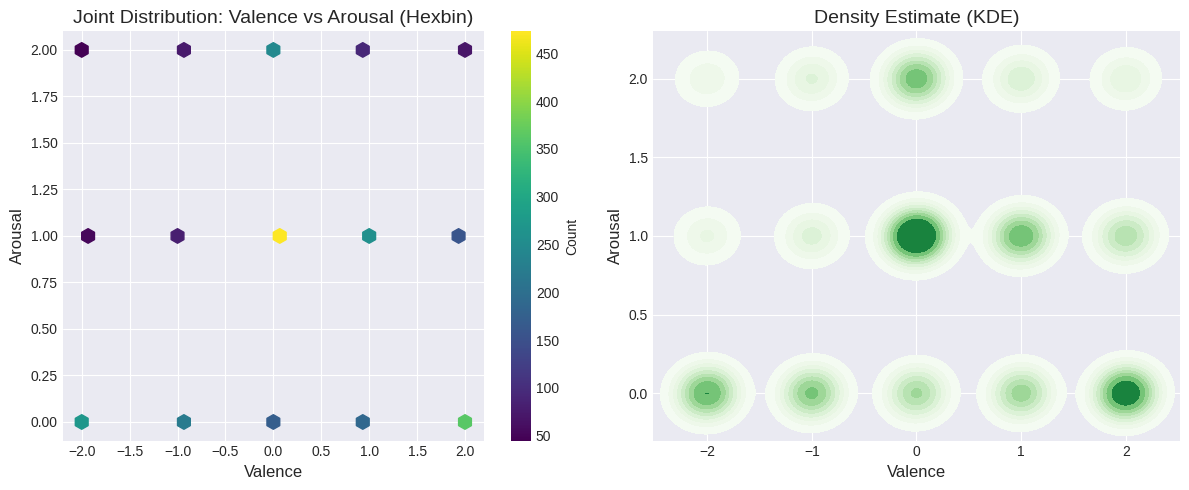

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Hexbin plot for density
hexbin = axes[0].hexbin(df1['valence'], df1['arousal'], gridsize=30, cmap='viridis', mincnt=1)
axes[0].set_xlabel('Valence', fontsize=12)
axes[0].set_ylabel('Arousal', fontsize=12)
axes[0].set_title('Joint Distribution: Valence vs Arousal (Hexbin)', fontsize=14)
plt.colorbar(hexbin, ax=axes[0], label='Count')

# 2D KDE plot
sns.kdeplot(data=df1, x='valence', y='arousal', ax=axes[1], fill=True, cmap='Greens', bw_adjust=0.5)
axes[1].set_xlabel('Valence', fontsize=12)
axes[1].set_ylabel('Arousal', fontsize=12)
axes[1].set_title('Density Estimate (KDE)', fontsize=14)

plt.tight_layout()
plt.show()


**Frequency of Emotional States**
Valence Range: Spans from -2 (strongly negative) to +2 (strongly positive), with a dense concentration around neutral to mildly positive values.

Arousal Range: Limited to 0-2, suggesting a scale where 0 is low energy and 2 is high energy.

High-Density Region: The most frequent emotional states cluster around valence ≈ 1 and arousal ≈ 1, indicating that users often report feeling moderately positive and moderately energized.

Sparse Extremes: Negative valence and low arousal combinations (e.g., sad and tired) are less frequent, as are high arousal with negative valence (e.g., angry or anxious), which may reflect either emotional norms or reporting biases in the dataset.

**Smoothed Emotional Density**
Core Emotional Zone: The KDE contours reinforce the hexbin findings, showing a peak density in the (1, 1) region.

Distribution Shape: The density is slightly skewed toward positive valence, suggesting a psychological or contextual bias toward reporting more pleasant emotions.

Modeling Implication: The smooth contours imply that valence and arousal are not independent — there's a tendency for higher valence to co-occur with moderate arousal, which could inform joint modeling strategies.

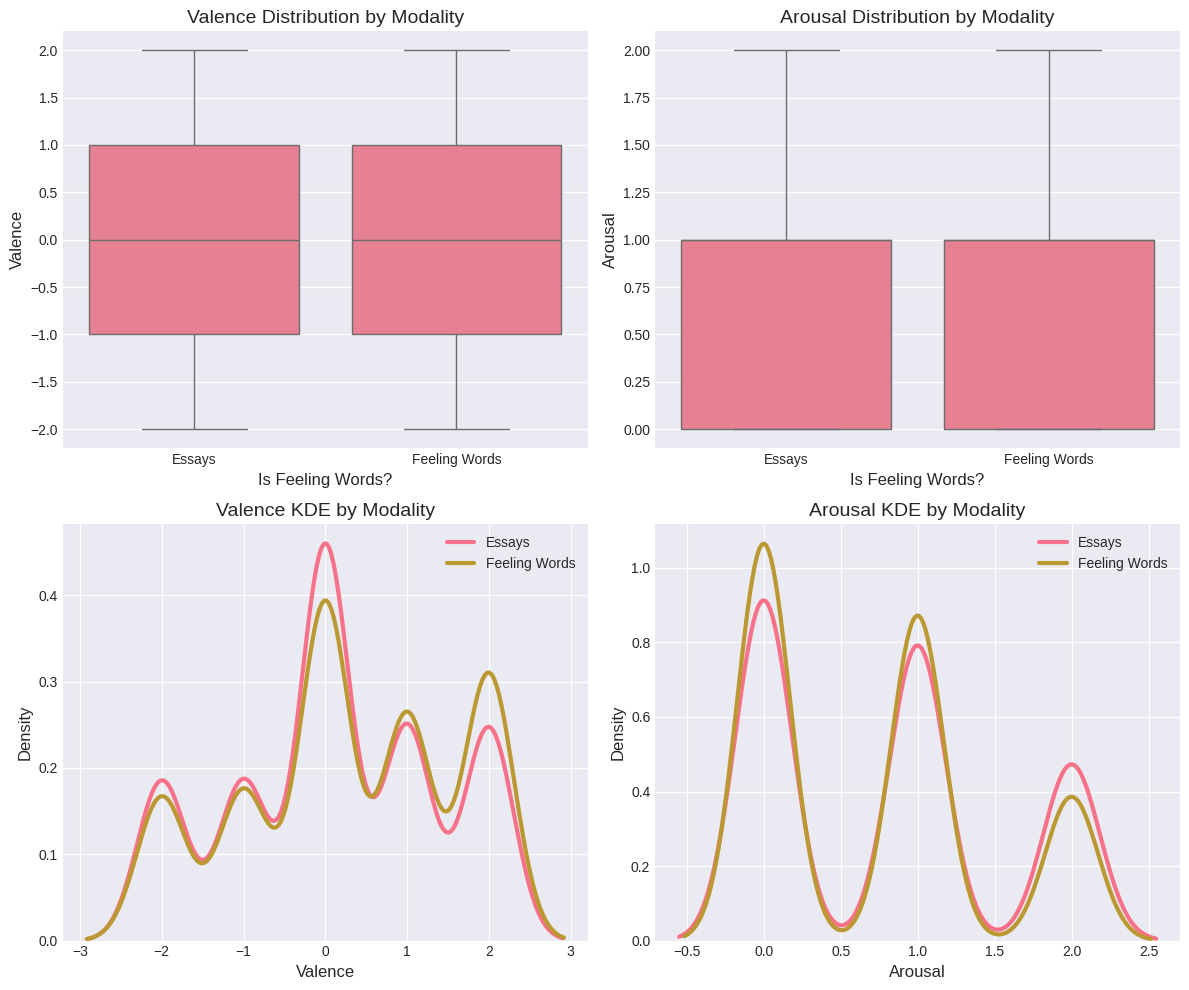

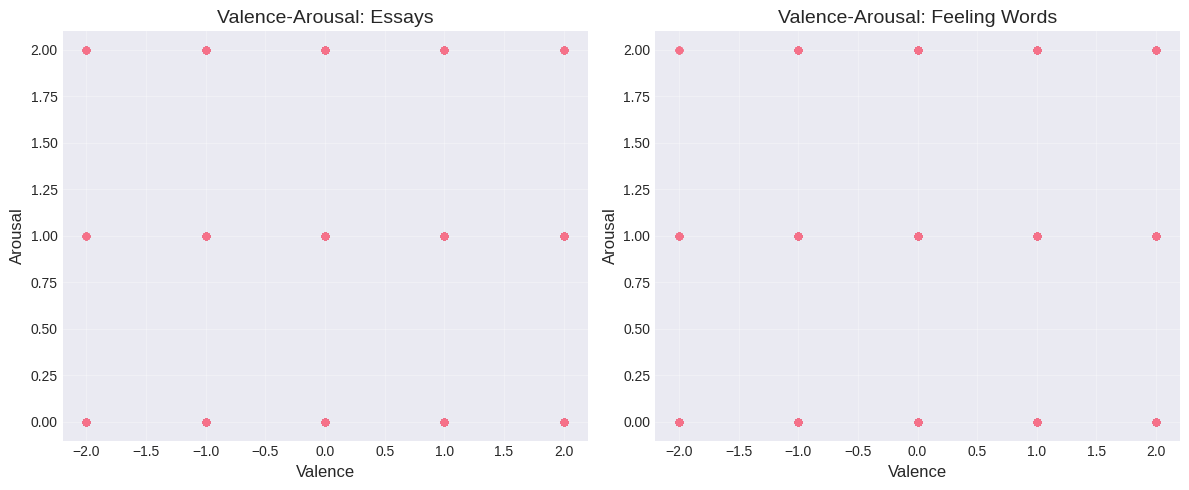

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Boxplots
sns.boxplot(data=df1, x='is_words', y='valence', ax=axes[0, 0])
axes[0, 0].set_xlabel('Is Feeling Words?', fontsize=12)
axes[0, 0].set_ylabel('Valence', fontsize=12)
axes[0, 0].set_title('Valence Distribution by Modality', fontsize=14)
axes[0, 0].set_xticklabels(['Essays', 'Feeling Words'])

sns.boxplot(data=df1, x='is_words', y='arousal', ax=axes[0, 1])
axes[0, 1].set_xlabel('Is Feeling Words?', fontsize=12)
axes[0, 1].set_ylabel('Arousal', fontsize=12)
axes[0, 1].set_title('Arousal Distribution by Modality', fontsize=14)
axes[0, 1].set_xticklabels(['Essays', 'Feeling Words'])

# Overlaid KDEs
sns.kdeplot(data=df1[df1['is_words'] == False], x='valence',
            label='Essays', ax=axes[1, 0], linewidth=3)
sns.kdeplot(data=df1[df1['is_words'] == True], x='valence',
            label='Feeling Words', ax=axes[1, 0], linewidth=3)
axes[1, 0].set_xlabel('Valence', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Valence KDE by Modality', fontsize=14)
axes[1, 0].legend()

sns.kdeplot(data=df1[df1['is_words'] == False], x='arousal',
            label='Essays', ax=axes[1, 1], linewidth=3)
sns.kdeplot(data=df1[df1['is_words'] == True], x='arousal',
            label='Feeling Words', ax=axes[1, 1], linewidth=3)
axes[1, 1].set_xlabel('Arousal', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].set_title('Arousal KDE by Modality', fontsize=14)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 2D distribution by modality
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for idx, (modality, label) in enumerate([(False, 'Essays'), (True, 'Feeling Words')]):
    subset = df1[df1['is_words'] == modality]
    scatter = axes[idx].scatter(subset['valence'], subset['arousal'],
                                alpha=0.5, s=20, label=label)
    axes[idx].set_xlabel('Valence', fontsize=12)
    axes[idx].set_ylabel('Arousal', fontsize=12)
    axes[idx].set_title(f'Valence-Arousal: {label}', fontsize=14)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Essays and feeling words show similar overall distributions for valence and arousal, but essays tend to express a wider emotional range and more nuanced intensity. KDE plots reveal that feeling words cluster more tightly around neutral-to-positive valence and mid-level arousal, while essays display multiple peaks, suggesting richer emotional variability. Scatter plots confirm that essays span the full affective space more evenly, whereas feeling words concentrate in common emotional zones. These differences support modeling the two modalities separately or with modality-aware architectures.

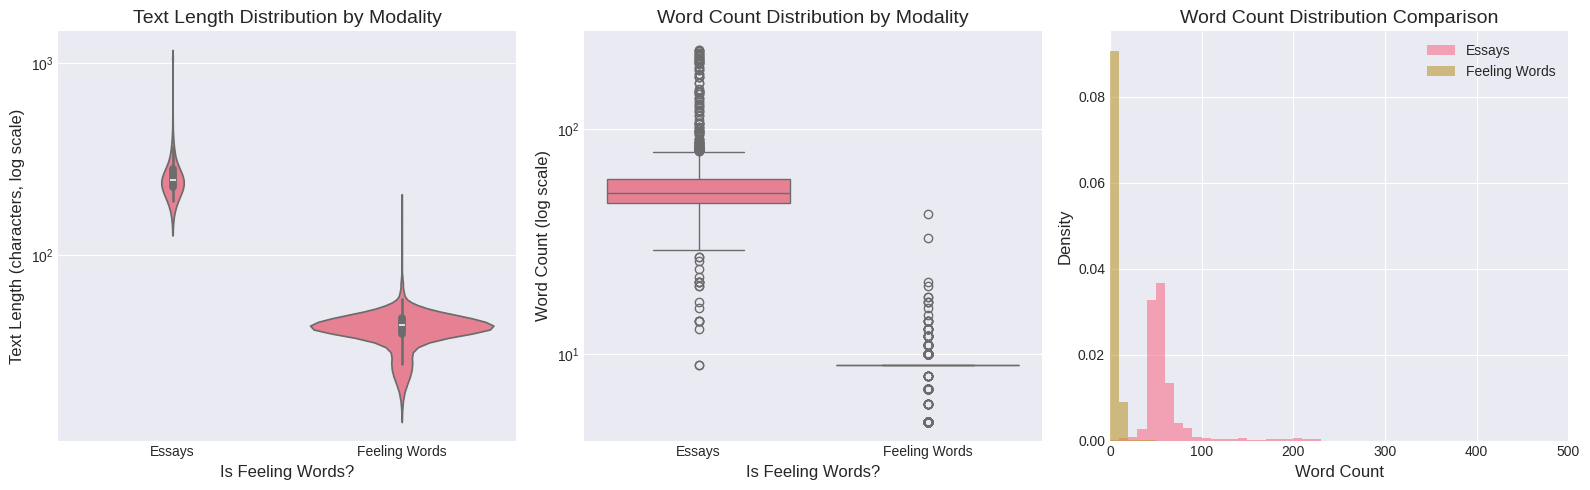

Text Length Statistics by Modality:
           count        mean         std    min    25%    50%    75%     max
is_words                                                                    
False     1331.0  282.805409  135.730495  191.0  225.0  245.0  281.0  1105.0
True      1433.0   43.199581    9.599920   18.0   39.0   43.0   47.0   203.0

Word Count Statistics by Modality:
           count       mean        std  min   25%   50%   75%    max
is_words                                                            
False     1331.0  58.755823  27.359836  9.0  47.0  52.0  60.0  225.0
True      1433.0   8.896720   1.793594  5.0   9.0   9.0   9.0   42.0


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Violin plot of text length
sns.violinplot(data=df1, x='is_words', y='text_length', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('Is Feeling Words?', fontsize=12)
axes[0].set_ylabel('Text Length (characters, log scale)', fontsize=12)
axes[0].set_title('Text Length Distribution by Modality', fontsize=14)
axes[0].set_xticklabels(['Essays', 'Feeling Words'])

# Boxplot of word count
sns.boxplot(data=df1, x='is_words', y='word_count', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('Is Feeling Words?', fontsize=12)
axes[1].set_ylabel('Word Count (log scale)', fontsize=12)
axes[1].set_title('Word Count Distribution by Modality', fontsize=14)
axes[1].set_xticklabels(['Essays', 'Feeling Words'])

# Histogram comparison
for modality, label in [(False, 'Essays'), (True, 'Feeling Words')]:
    subset = df1[df1['is_words'] == modality]
    axes[2].hist(subset['word_count'], bins=50, alpha=0.6,
                 label=label, density=True, range=(0, 500))
axes[2].set_xlabel('Word Count', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Word Count Distribution Comparison', fontsize=14)
axes[2].legend()
axes[2].set_xlim(0, 500)

plt.tight_layout()
plt.show()

print("Text Length Statistics by Modality:")
print(df1.groupby('is_words')['text_length'].describe())
print("\nWord Count Statistics by Modality:")
print(df1.groupby('is_words')['word_count'].describe())

Essays are significantly longer and more variable than feeling words, both in character length and word count. Violin and box plots show that essays have a higher median and broader spread, while feeling words are short and tightly clustered. The histogram confirms this contrast: essay word counts peak around 50–75 words, whereas feeling words concentrate near 9 words. These differences highlight the need for modality-aware preprocessing and suggest that essays may require more complex sequence modeling than feeling words.

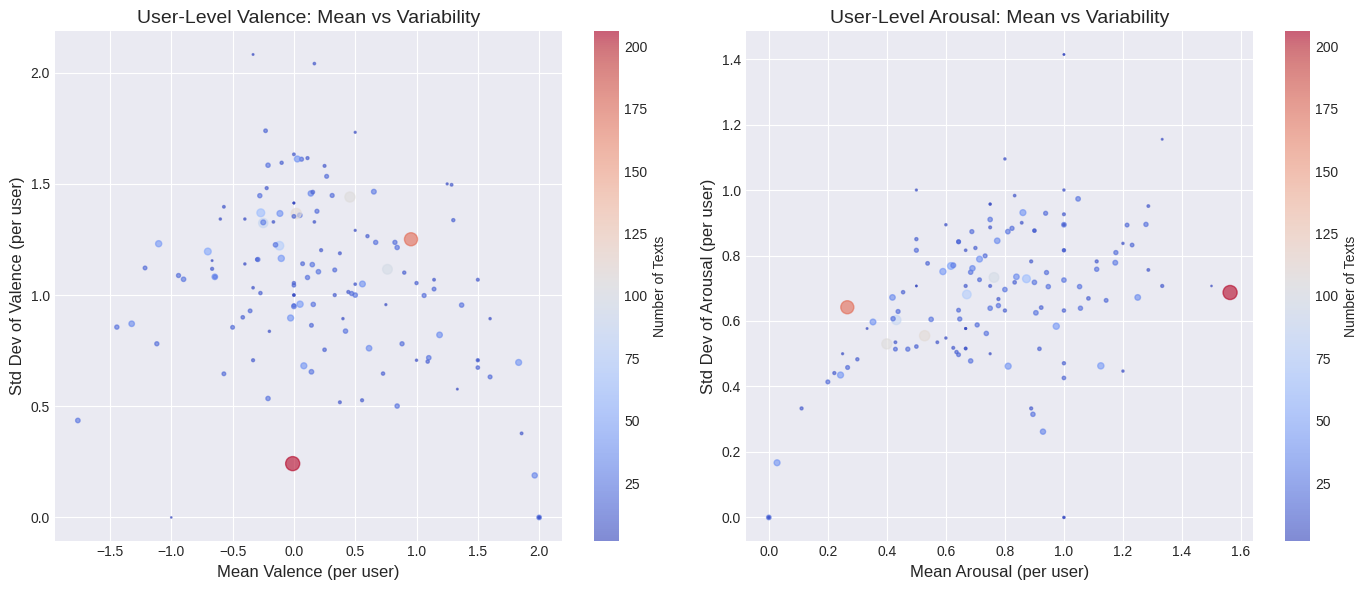

User-Level Statistics Summary:
Number of users: 137
Average texts per user: 20.2
Median texts per user: 14.0

Valence - Between-user variance: 0.611
Valence - Within-user variance (avg): 1.048

Arousal - Between-user variance: 0.099
Arousal - Within-user variance (avg): 0.671


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# User-level variance vs mean
user_stats = df1.groupby('user_id').agg({
    'valence': ['mean', 'std'],
    'arousal': ['mean', 'std'],
    'text_id': 'count'
}).round(3)

user_stats.columns = ['valence_mean', 'valence_std',
                      'arousal_mean', 'arousal_std', 'text_count']

# Plot 1: Valence mean vs std
scatter1 = axes[0].scatter(user_stats['valence_mean'], user_stats['valence_std'],
                          s=user_stats['text_count']/2, alpha=0.6,
                          c=user_stats['text_count'], cmap='coolwarm')
axes[0].set_xlabel('Mean Valence (per user)', fontsize=12)
axes[0].set_ylabel('Std Dev of Valence (per user)', fontsize=12)
axes[0].set_title('User-Level Valence: Mean vs Variability', fontsize=14)
plt.colorbar(scatter1, ax=axes[0], label='Number of Texts')

# Plot 2: Arousal mean vs std
scatter2 = axes[1].scatter(user_stats['arousal_mean'], user_stats['arousal_std'],
                          s=user_stats['text_count']/2, alpha=0.6,
                          c=user_stats['text_count'], cmap='coolwarm')
axes[1].set_xlabel('Mean Arousal (per user)', fontsize=12)
axes[1].set_ylabel('Std Dev of Arousal (per user)', fontsize=12)
axes[1].set_title('User-Level Arousal: Mean vs Variability', fontsize=14)
plt.colorbar(scatter2, ax=axes[1], label='Number of Texts')

plt.tight_layout()
plt.show()

print("User-Level Statistics Summary:")
print("=" * 50)
print(f"Number of users: {len(user_stats)}")
print(f"Average texts per user: {user_stats['text_count'].mean():.1f}")
print(f"Median texts per user: {user_stats['text_count'].median():.1f}")
print(f"\nValence - Between-user variance: {user_stats['valence_mean'].var():.3f}")
print(f"Valence - Within-user variance (avg): {user_stats['valence_std'].mean():.3f}")
print(f"\nArousal - Between-user variance: {user_stats['arousal_mean'].var():.3f}")
print(f"Arousal - Within-user variance (avg): {user_stats['arousal_std'].mean():.3f}")

Users show greater emotional variability within themselves than between each other, especially for valence. The average within-user variance for valence (1.048) exceeds the between-user variance (0.611), suggesting that individuals fluctuate more over time than they differ from one another. Arousal shows a similar but weaker pattern, with lower overall variability. Scatter plots confirm this: users with more texts tend to exhibit broader emotional ranges, and there's no strong clustering by mean scores. These findings highlight the importance of modeling temporal dynamics and individual trajectories in affect prediction.

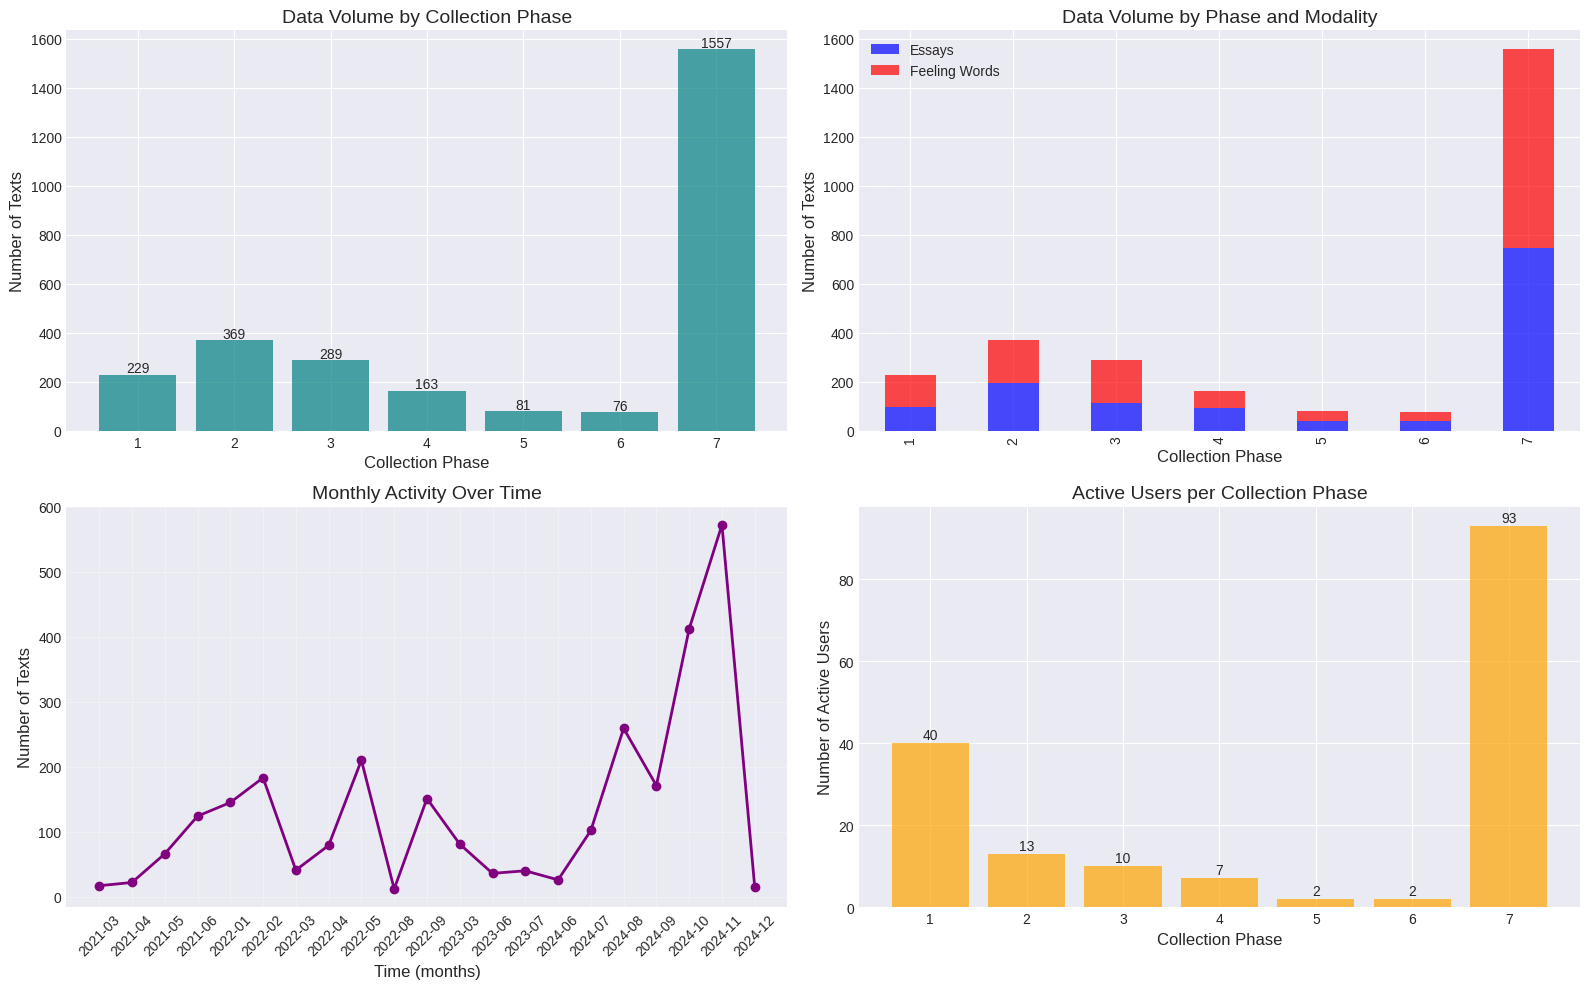

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Data volume per collection phase
phase_counts = df1['collection_phase'].value_counts().sort_index()
axes[0, 0].bar(phase_counts.index, phase_counts.values, color='teal', alpha=0.7)
axes[0, 0].set_xlabel('Collection Phase', fontsize=12)
axes[0, 0].set_ylabel('Number of Texts', fontsize=12)
axes[0, 0].set_title('Data Volume by Collection Phase', fontsize=14)
for i, v in enumerate(phase_counts.values):
    axes[0, 0].text(i+1, v + 10, str(v), ha='center', fontsize=10)

# Plot 2: Data volume per phase by modality
phase_modality_counts = df1.groupby(['collection_phase', 'is_words']).size().unstack()
phase_modality_counts.plot(kind='bar', stacked=True, ax=axes[0, 1],
                          color=['blue', 'red'], alpha=0.7)
axes[0, 1].set_xlabel('Collection Phase', fontsize=12)
axes[0, 1].set_ylabel('Number of Texts', fontsize=12)
axes[0, 1].set_title('Data Volume by Phase and Modality', fontsize=14)
axes[0, 1].legend(['Essays', 'Feeling Words'])

# Plot 3: Monthly activity over time
df1['year_month'] = df1['timestamp'].dt.to_period('M')
monthly_counts = df1.groupby('year_month').size()
axes[1, 0].plot(range(len(monthly_counts)), monthly_counts.values,
                marker='o', linewidth=2, color='purple')
axes[1, 0].set_xlabel('Time (months)', fontsize=12)
axes[1, 0].set_ylabel('Number of Texts', fontsize=12)
axes[1, 0].set_title('Monthly Activity Over Time', fontsize=14)
axes[1, 0].set_xticks(range(len(monthly_counts)))
axes[1, 0].set_xticklabels([str(period) for period in monthly_counts.index], rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Number of active users per phase
users_per_phase = df1.groupby('collection_phase')['user_id'].nunique()
axes[1, 1].bar(users_per_phase.index, users_per_phase.values, color='orange', alpha=0.7)
axes[1, 1].set_xlabel('Collection Phase', fontsize=12)
axes[1, 1].set_ylabel('Number of Active Users', fontsize=12)
axes[1, 1].set_title('Active Users per Collection Phase', fontsize=14)
for i, v in enumerate(users_per_phase.values):
    axes[1, 1].text(i+1, v + 1, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Phase 7 dominates the dataset with over 1,500 texts and the highest number of active users (93), indicating a major expansion in data collection. Earlier phases show more modest activity, with Phase 2 being the next most active. The modality breakdown reveals that Phase 7 includes a surge in both essays and feeling words, while earlier phases lean more heavily toward essays. Monthly trends show bursts of activity, especially in late 2024, suggesting episodic collection efforts. These patterns imply that temporal and phase-based stratification may be crucial for modeling and evaluation.

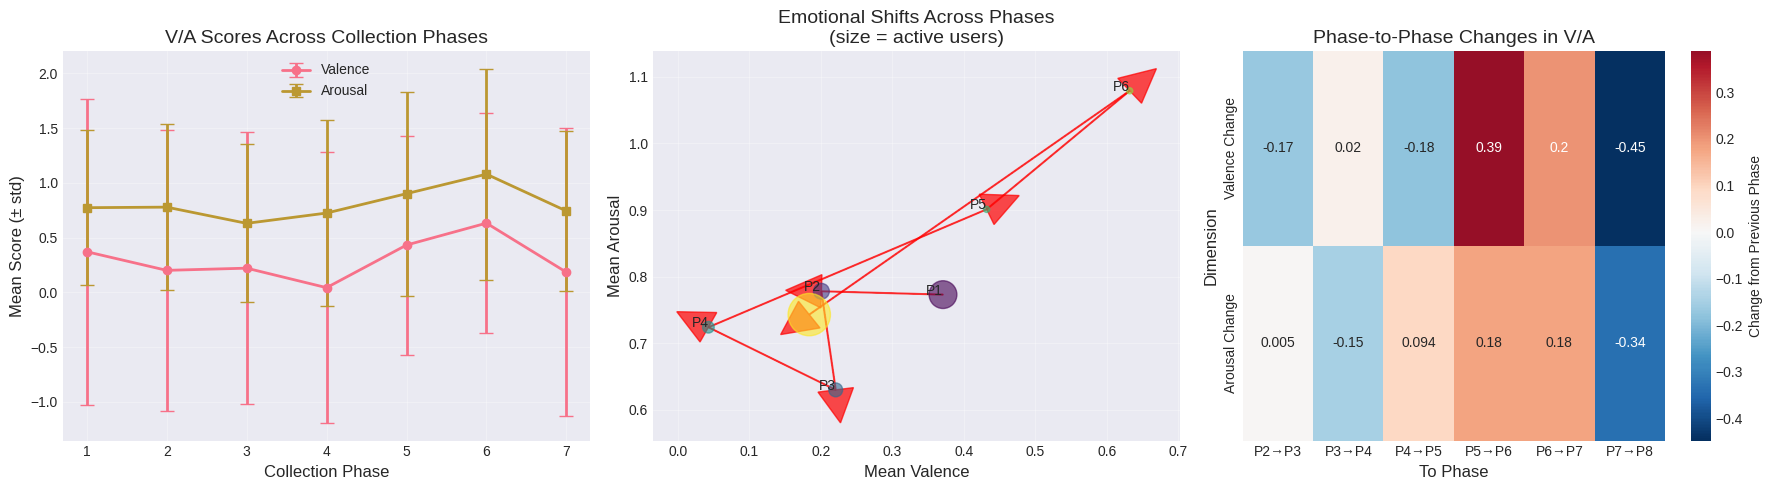

In [11]:
# Calculate phase-level statistics
phase_stats = df1.groupby('collection_phase').agg({
    'valence': ['mean', 'std'],
    'arousal': ['mean', 'std'],
    'user_id': 'nunique'
}).round(3)

phase_stats.columns = ['valence_mean', 'valence_std',
                       'arousal_mean', 'arousal_std', 'unique_users']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Valence and arousal trends across phases
phases = phase_stats.index
axes[0].errorbar(phases, phase_stats['valence_mean'],
                 yerr=phase_stats['valence_std'],
                 label='Valence', marker='o', linewidth=2, capsize=5)
axes[0].errorbar(phases, phase_stats['arousal_mean'],
                 yerr=phase_stats['arousal_std'],
                 label='Arousal', marker='s', linewidth=2, capsize=5)
axes[0].set_xlabel('Collection Phase', fontsize=12)
axes[0].set_ylabel('Mean Score (± std)', fontsize=12)
axes[0].set_title('V/A Scores Across Collection Phases', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Phase transition arrows
for i in range(len(phases)-1):
    axes[1].arrow(phase_stats['valence_mean'].iloc[i],
                  phase_stats['arousal_mean'].iloc[i],
                  phase_stats['valence_mean'].iloc[i+1] - phase_stats['valence_mean'].iloc[i],
                  phase_stats['arousal_mean'].iloc[i+1] - phase_stats['arousal_mean'].iloc[i],
                  head_width=0.05, head_length=0.05, fc='red', ec='red', alpha=0.7)
    axes[1].text(phase_stats['valence_mean'].iloc[i],
                 phase_stats['arousal_mean'].iloc[i],
                 f'P{phases[i]}', fontsize=10, ha='right')

axes[1].scatter(phase_stats['valence_mean'], phase_stats['arousal_mean'],
                s=phase_stats['unique_users']*10, alpha=0.6, c=phases, cmap='viridis')
axes[1].set_xlabel('Mean Valence', fontsize=12)
axes[1].set_ylabel('Mean Arousal', fontsize=12)
axes[1].set_title('Emotional Shifts Across Phases\n(size = active users)', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Plot 3: Heatmap of phase differences
phase_diffs = pd.DataFrame({
    'Valence Change': phase_stats['valence_mean'].diff(),
    'Arousal Change': phase_stats['arousal_mean'].diff()
}).iloc[1:]

sns.heatmap(phase_diffs.T, annot=True, cmap='RdBu_r', center=0,
            ax=axes[2], cbar_kws={'label': 'Change from Previous Phase'})
axes[2].set_xlabel('To Phase', fontsize=12)
axes[2].set_ylabel('Dimension', fontsize=12)
axes[2].set_title('Phase-to-Phase Changes in V/A', fontsize=14)
axes[2].set_xticklabels([f'P{i}→P{i+1}' for i in range(2, 8)])

plt.tight_layout()
plt.show()

Valence and arousal scores fluctuate across collection phases, with notable emotional shifts in later stages. Phase 6 shows a sharp rise in valence (+0.39) and arousal (+0.18), followed by a drop in Phase 7, suggesting a temporary uplift in mood and energy. The transition plot visualizes these shifts, with arrows tracing emotional trajectories and point sizes reflecting user engagement. The heatmap quantifies these changes, highlighting Phase 6 as a turning point. These patterns imply that emotional dynamics vary meaningfully over time, reinforcing the need for phase-aware modeling in longitudinal affect prediction.

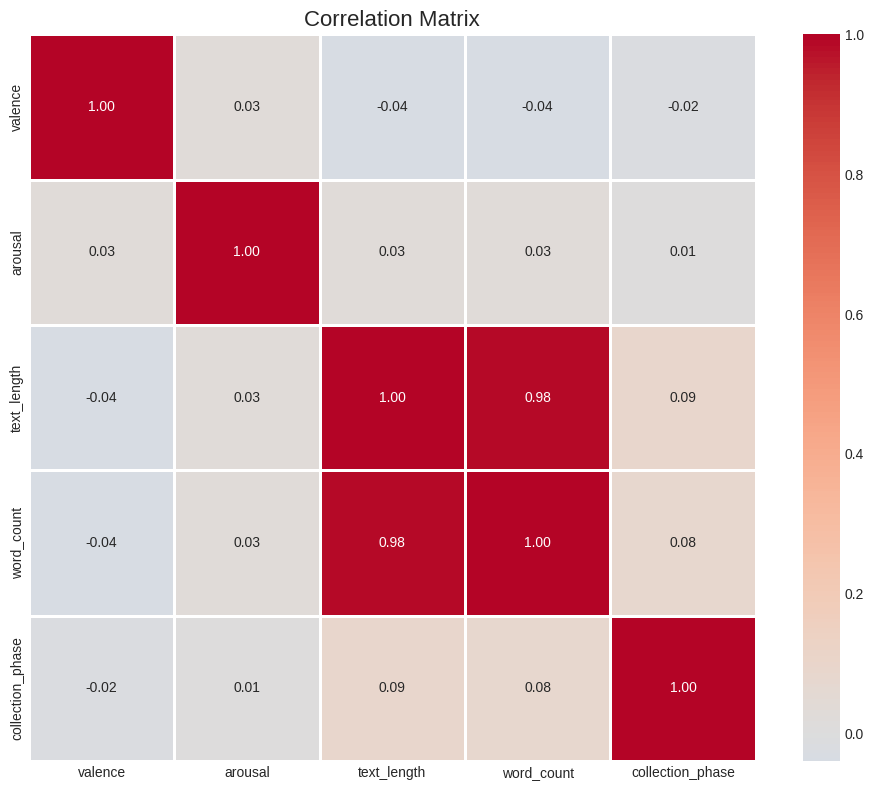

In [19]:
# Correlation matrix
correlation_cols = ['valence', 'arousal', 'text_length', 'word_count', 'collection_phase']
corr_matrix = df1[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', linewidths=1)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

Valence and arousal show minimal correlation with each other and with structural features like text length or word count, suggesting that emotional scores are largely independent of how much someone writes. Text length and word count, however, are highly correlated (r = 0.98), as expected. Collection phase has weak associations with all variables, indicating that emotional and textual patterns are relatively stable across phases. These insights support treating valence and arousal as distinct targets and suggest that text quantity alone doesn't predict emotional intensity.

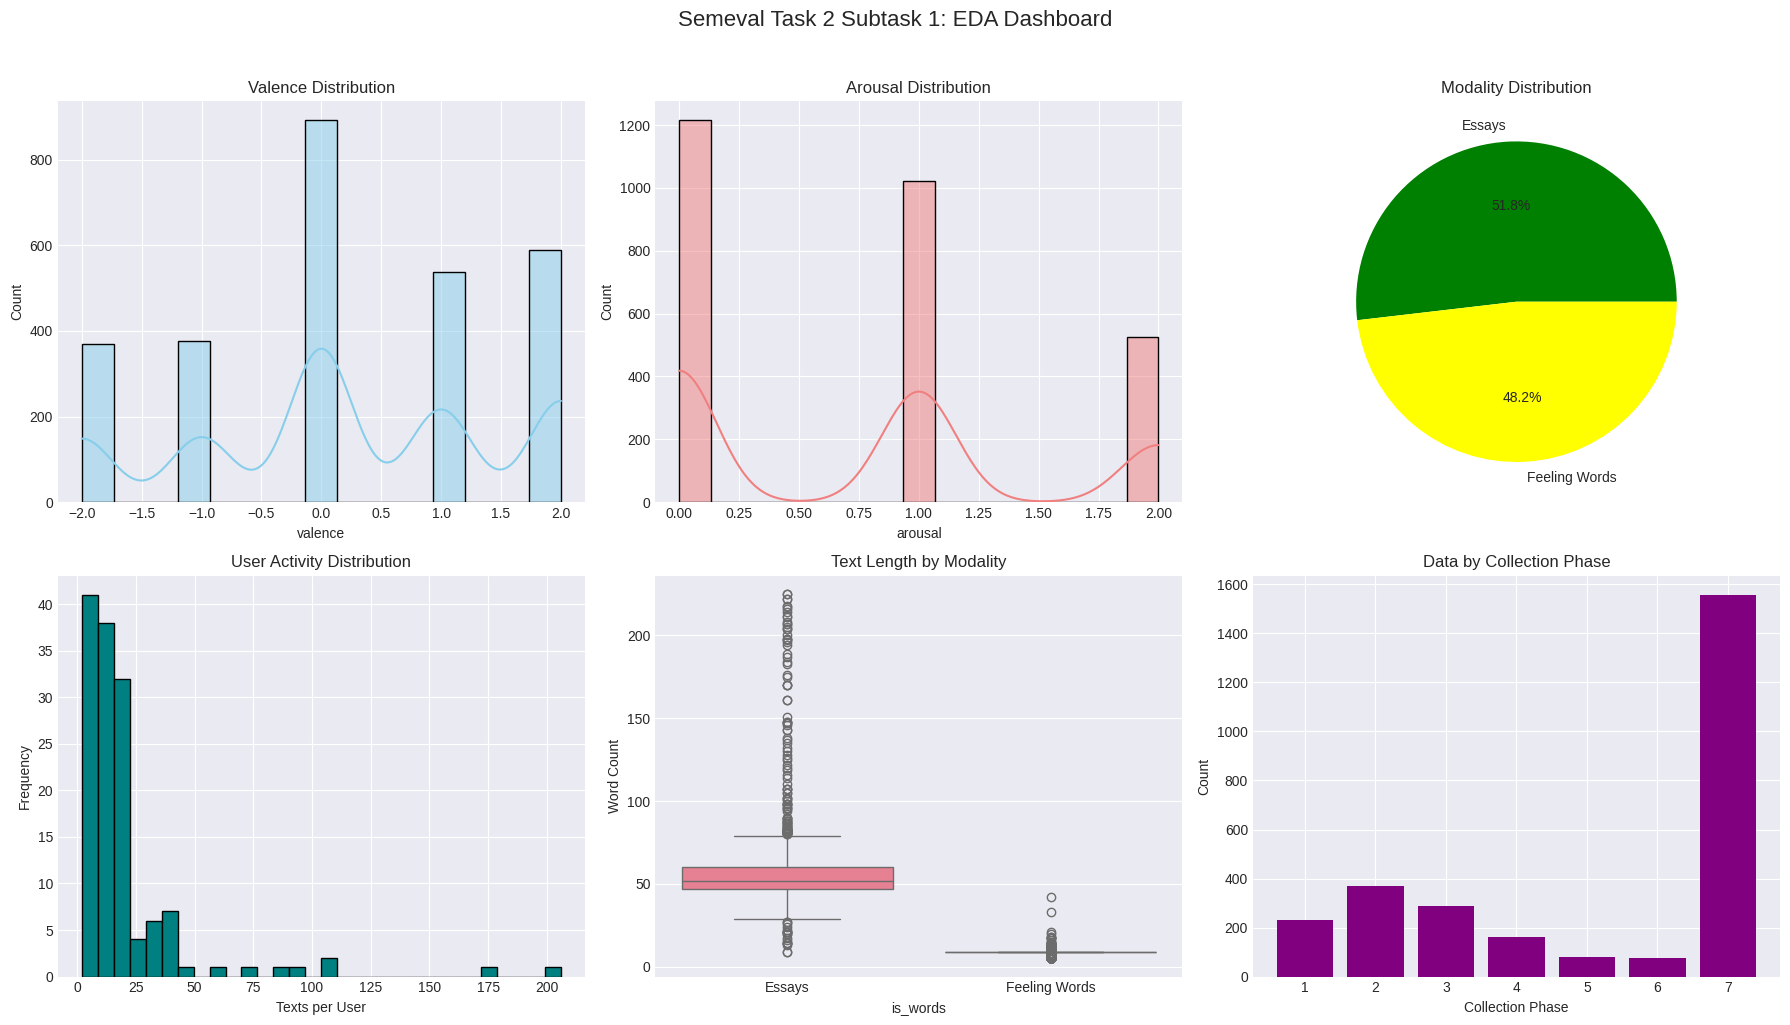

In [18]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3)

# 1. Valence distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(df1['valence'], kde=True, ax=ax1, color='skyblue')
ax1.set_title('Valence Distribution', fontsize=12)

# 2. Arousal distribution
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(df1['arousal'], kde=True, ax=ax2, color='lightcoral')
ax2.set_title('Arousal Distribution', fontsize=12)

# 3. Modality distribution
ax3 = fig.add_subplot(gs[0, 2])
modality_counts = df1['is_words'].value_counts()
ax3.pie(modality_counts.values, labels=['Essays', 'Feeling Words'],
        autopct='%1.1f%%', colors=['green', 'yellow'])
ax3.set_title('Modality Distribution', fontsize=12)

# 4. User activity
ax4 = fig.add_subplot(gs[1, 0])
user_activity.hist(bins=30, ax=ax4, color='teal', edgecolor='black')
ax4.set_xlabel('Texts per User')
ax4.set_ylabel('Frequency')
ax4.set_title('User Activity Distribution', fontsize=12)

# 5. Text length by modality
ax5 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=df1, x='is_words', y='word_count', ax=ax5)
ax5.set_xticklabels(['Essays', 'Feeling Words'])
ax5.set_ylabel('Word Count')
ax5.set_title('Text Length by Modality', fontsize=12)

# 6. Phase distribution
ax6 = fig.add_subplot(gs[1, 2])
phase_counts = df1['collection_phase'].value_counts().sort_index()
ax6.bar(phase_counts.index, phase_counts.values, color='purple')
ax6.set_xlabel('Collection Phase')
ax6.set_ylabel('Count')
ax6.set_title('Data by Collection Phase', fontsize=12)

plt.suptitle('Semeval Task 2 Subtask 1: EDA Dashboard', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The EDA reveals several structural and behavioral patterns that shape the modeling challenges in SemEval Task 2 Subtask 1. Essays and feeling words differ sharply in length and variability, with essays being much longer and more diverse, while feeling words remain short and consistent, making modality‑aware modeling essential. Valence and arousal cluster around neutral and mid‑range values, with sparse extremes, which introduces class imbalance and makes fine‑grained affect prediction harder. Users fluctuate more within themselves than they differ from one another, especially in valence, highlighting the importance of capturing individual emotional trajectories rather than relying solely on global patterns. Emotional trends also shift across collection phases, with notable jumps in later phases, suggesting that temporal context influences affective expression. Phase 7 dominates the dataset in both volume and user participation, creating potential biases if not properly stratified. Finally, emotional scores show almost no correlation with text length or word count, reinforcing that semantic content—not structural features—drives affective meaning.